# Chapter 5 - Classification

Import required Python packages.

In [59]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [60]:
LOAN3000_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\loan3000.csv"
LOAN_DATA_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\loan_data.csv"
FULL_TRAIN_SET_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\full_train_set.csv"

# The Naive Solution

In _Python_ we can use `sklearn.naive_bayes.MultinomialNB` from `scikit-learn`. We need to convert the categorical features to dummy variables before we fit the model:

In [62]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model.fit(X, y)

MultinomialNB(alpha=1e-10, fit_prior=False)

It is possible to derive the conditional probabilities from the fitted modeul using property `feature_log_prob`. The model can be used to predict the outcome of a new loan. We use the last value of the data set for testing:

In [64]:
new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

predicted class:  default


`scikit-learn` classification models have 2 methods - `predict`, which returns the predicted class, and `predict_proba`, which returns the class probabilities:

In [66]:
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                            columns=loan_data[outcome].cat.categories)
print('predicted probabilities', probabilities)

predicted probabilities     default  paid off
0  0.653699  0.346301


The prediction also returns a `posterior` estimate of the probability of default. The naive Bayesian classifier is known to produce _biased_ estimates. However, where the goal is to _rank_ records according to the probability that Y=1, unbiased estimates of probability are not needed, and naive Bayes produces good results.

# A Simple Example

In _Python_, we can use `LinearDiscriminantAnalysis` from `sklearn.discriminant_analysis`. The `scalings_` property gives the estimated weights:

In [69]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
pd.DataFrame(loan_lda.scalings_, index=X.columns)

,0
borrower_score,7.175839
payment_inc_ratio,-0.099676


The `predict_proba` method of the fitted model returns the probabilities for the "default" and "paid off" outcomes:

In [71]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                   columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


A plot of the predictions helps illustrate how LDA works. Using the out from the `predict_proba` function, a plot of estimated probability of default is produced as follows:

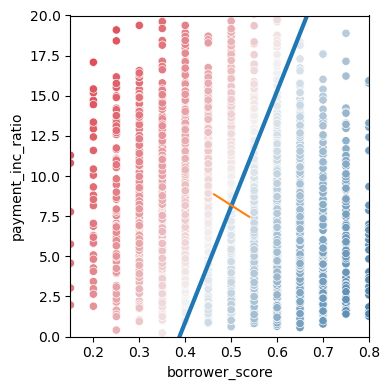

In [73]:
# Figure5-1 
# Use scalings and center of means to determine decisiion boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ration for borrower_score of 0 & 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis = 1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4,4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                   hue='default', data=lda_df,
                   palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                   ax=ax, legend=False)

ax.set_ylim(0,20)
ax.set_xlim(0.15,0.8)
ax.plot((x_0, x_20), (0,20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

# Logistic Regression

# Logistic Response Funciton and Logit

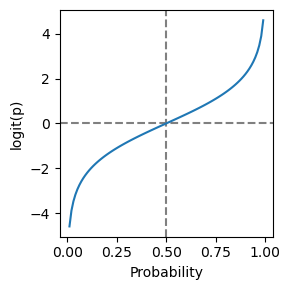

In [75]:
# Figure 5 - 2
p = np.arange(0.01,1,0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1-p)),
    'odds': p / (1-p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

# Logistic Regression and the GLM

The package _scikit-learn_ has a specialised class for `LogisticRegression`. _Statsmodels_ have more general method based on generalized linear model (GLM). The arguments `penalty` and `C` are used to prevent overfitting by L1 and L2 regularization. Regularization is switched on by default. In order to fit without regularization, we set `C` to a very large value. The `solver` argument selects the used minimizer; the method `liblinear` is the default:

In [77]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_',
             'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='',
                  drop_first=True)
y = loan_data[outcome]

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]},
            index=X.columns)

intercept  -1.638088683407208
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229376
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048453
RENT,-0.157355


In [78]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

AttributeError: Can only use .cat accessor with a 'category' dtype

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]},
            index=X.columns)

# Predicted Values from Logistic Regression

In _Python_, we can convert the probabilities into a data frame and use the `describe` method to get these characteristics of the distribution:

In [ ]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                   columns=loan_data[outcome].cat.categories)
pred.describe()

The probabilities are directly available using the `predict_proba` in `scikit-learn`:

In [ ]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                   columns=loan_data[outcome].cat.categories)
pred.describe()

# Interpreting the Coefficients and Odds Ratios

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(df['logit'],df['odds'])
ax.set_xlabel('log(odds ratio)')
ax.set_ylabel('odds ratio')
ax.set_xlim(0,5.1)
ax.set_ylim(-5,105)

plt.tight_layout()
plt.show()

# Assessing the Model

The package `statsmodels` has an implementation for generalized linear model (GLM) that provides similarly detailed information:

In [ ]:
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

The formula interface of `statsmodels` also supports these extensions in _Python_:

In [ ]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=4) + purpose_ + ' + 
           'home_ + emp_len_ + bs(borrower_score, df=4)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

## Analysis of residuals

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLMResults

def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parameters of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i]=0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/2
    })
    results = results.sort_values(by=['feature'])
    
    ax.scatter(results.feature, results.residual, marker='.', s=72/fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual - {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5,5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

# Confusion Matrix

In [ ]:
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & ~pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)],
                        [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

# Precision, Recall, and Specificity

To calculate the 3 metrics in _Python_:

`scikit-learn` has a custom method `precision_recall_fscore_support` that calculates precision and recall/specificity all at once.

In [ ]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0,0]/sum(conf_mat[:,0]))
print('Recall', conf_mat[0,0]/sum(conf_mat[0, :]))
print('Specificity', conf_mat[1,1]/sum(conf_mat[1, :]))

precision_recall_fscore_support(y, logit_reg.predict(X),
                               labels=['default', 'paid off'])

# ROC Curve

This metric captures the trade-off between recall and specificity. In _Python_, we can use the `scikit-learn` function `sklearn.metrics.roc_curve` to calculate the required information for the ROC curve.

In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0],
                                pos_label='default')
roc_df = pd.DataFrame({'recall': tpr,'specificity':1 - fpr})

ax = roc_df.plot(x='specificity',y='recall',figsize=(4,4),legend=False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

plt.tight_layout()
plt.show()

# AUC

It is simply the total area under the ROC curve. The larger the value of AUC, the more effective the classifier.

In _Python_, we can either calculate the accuracy as shown for _R_ or use `scikit-learn` function `sklearn.metrics.roc_auc_score`. You will need to provide the expected value as 0 or 1:

In [ ]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y],
                   logit_reg.predict_proba(X)[:,0]))

In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0],
                                pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4),legend=False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)

ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)

plt.tight_layout()
plt.show()

# Strategies for Imbalanced Data

# Undersample

In [ ]:
full_train_set = pd.read_csv(FULL_TRAIN_SET_CSV)
print(full_train_set.shape)

In [99]:
print('percentage of loans in default: ', 
print(      100 * np.mean(full_train_set.outcome == 'default')))

18.894546909248504
percentage of loans in default:  None


In [103]:
# What happens if we use the full data set to train the model?
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', 
                   drop_first=True, dtype=int)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('percentage of loans predicted to default: ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

0.0
percentage of loans predicted to default:  None


# Oversampling and Up/Down Weighting

Most `scikit-learn` methods allows specifying weights in the `fit` function using the keyword argument `sample_weight`:

In [107]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 
      for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y, sample_weight=wt)
print('percentage of loans predicted to default (weighting): ', 
      100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default (weighting):  61.43998933217766


# Data Generation

The _Python_ package `imbalanced-learn` implements a variety of methods with an API that is compatible with `scikit-learn`. It provides various methods for over- and undersampling and support for using these techniques with boosting and bagging classifiers.

In [109]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('percentage of loans predicted to default (SMOTE resampled): ',
     100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (SMOTE): ',
     100 * np.mean(full_model.predict(X) == 'default'))

X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('percentage of loans predicted to default (ADASYN resampled): ',
     100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('percentage of loans predicted to default (ADASYN): ',
     100 * np.mean(full_model.predict(X) == 'default'))

percentage of loans predicted to default (SMOTE resampled):  50.0
percentage of loans predicted to default (SMOTE):  29.29317342712127
percentage of loans predicted to default (ADASYN resampled):  48.56040383751355
percentage of loans predicted to default (ADASYN):  27.281288806287346


# Exploring the predictions

In [116]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                  min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)

# model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


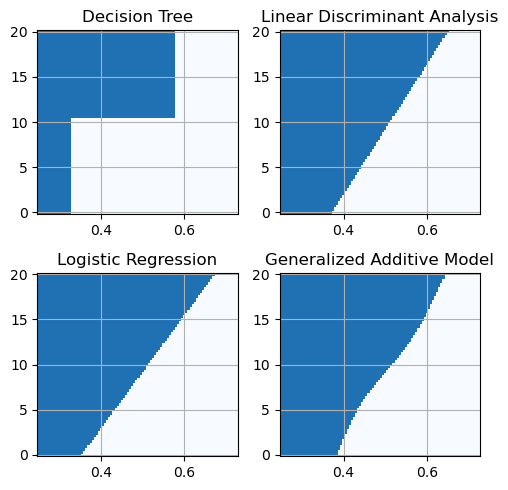

In [135]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols =2, figsize=(5,5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = pd.DataFrame({
    'borrower_score': xx.ravel(),
    'payment_inc_ratio': yy.ravel(),
})

boundary = {}

# for loop
for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] ==0] = yvalues[-1]
    
    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3,
                     shading='auto')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

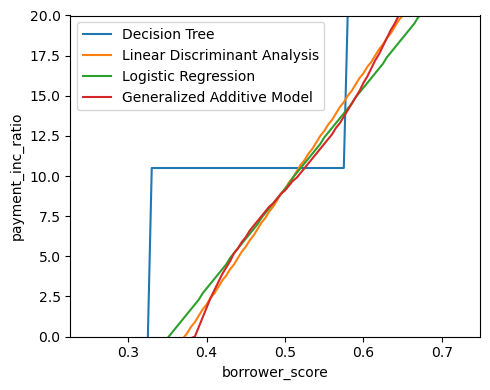

In [139]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

fig, ax = plt.subplots(figsize=(5,4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)

plt.tight_layout()
plt.show()